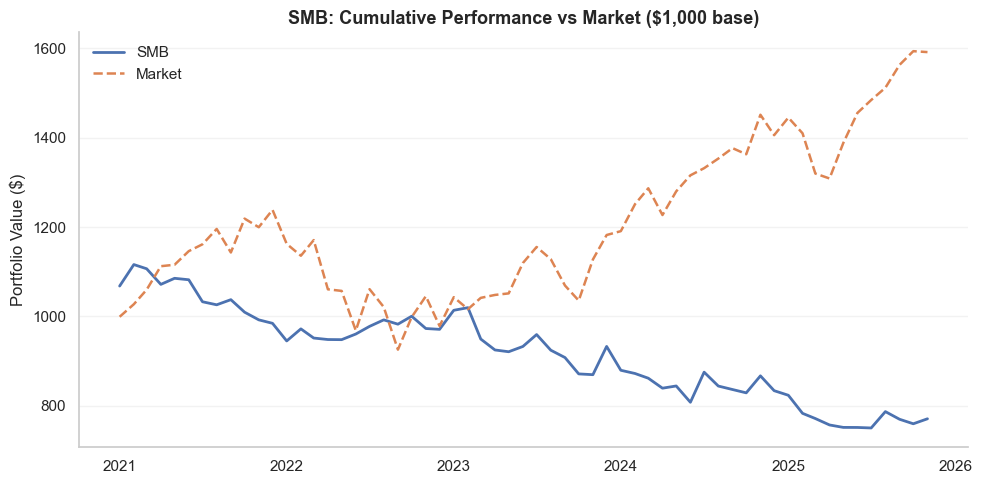

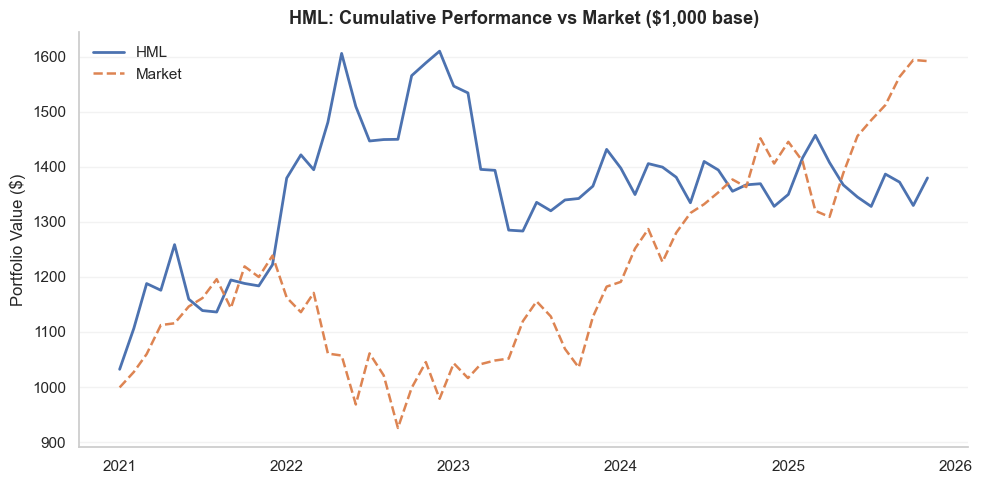

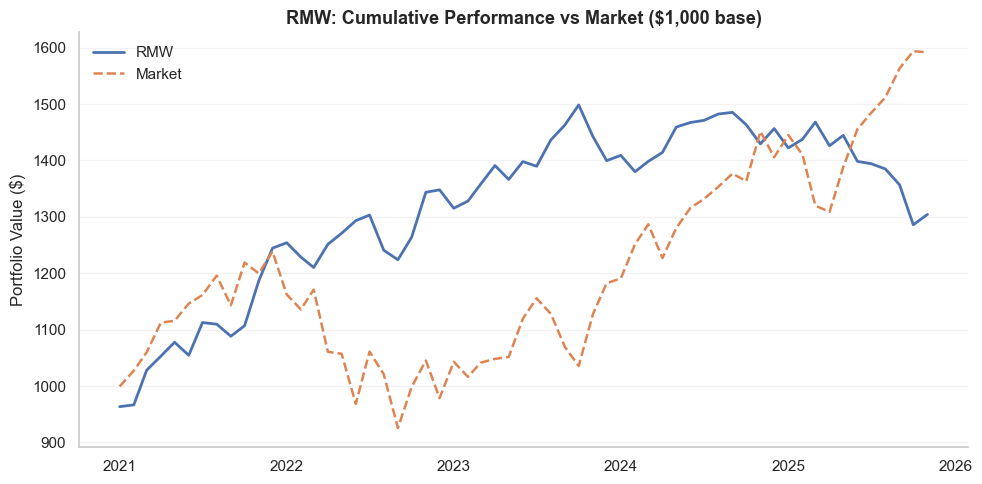

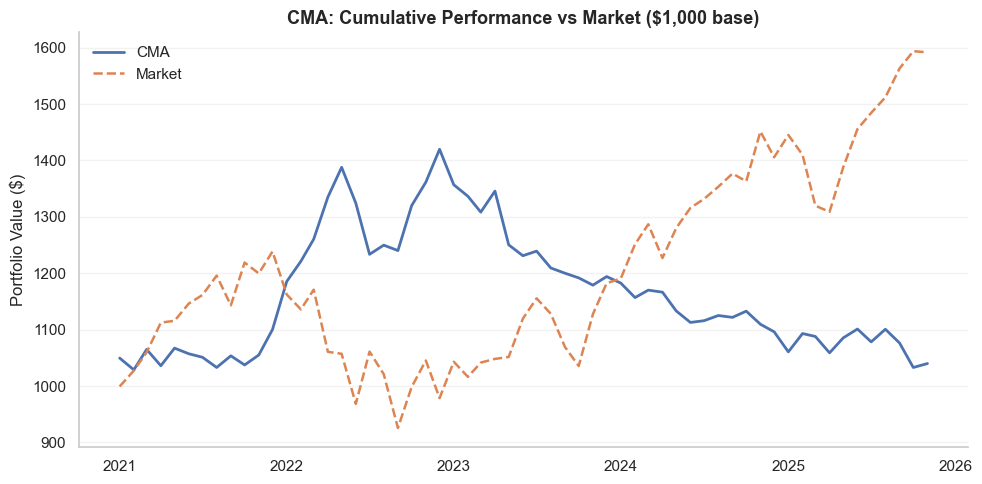

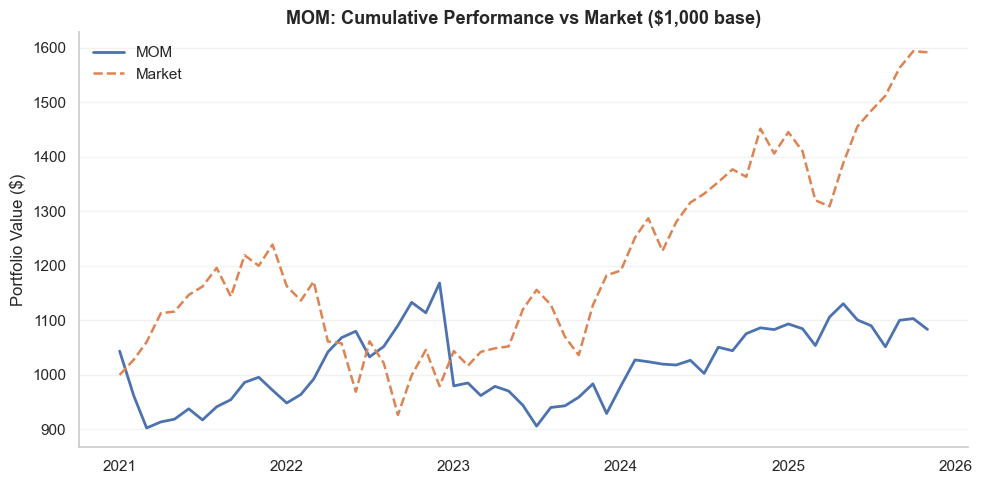

In [27]:
# ============================================================
# FACTOR BACKTESTING — FF5 + MOM (MONTHLY, 2007–PRESENT)
# CQF / BL READY — POLISHED OUTPUT
# ============================================================

import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas_datareader import data as pdr
from matplotlib.ticker import FuncFormatter

# ------------------------------------------------------------
# SUPPRESS NOISY WARNINGS (pandas_datareader only)
# ------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
START_DATE = "2007-01-01"
BASE_VALUE = 1000
ROLLING_WINDOW = 36
ANNUALIZATION = 12

OUT_DIR = (
    "/Users/dave/PythonProject1/PythonProject1/"
    "PythonProject/PythonProject/data/processed/Factor Backtesting"
)

FIG_DIR = os.path.join(OUT_DIR, "figures")
TAB_DIR = os.path.join(OUT_DIR, "tables")

os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

# ------------------------------------------------------------
# STYLE
# ------------------------------------------------------------
sns.set_theme(style="white", font_scale=0.9)
plt.rcParams["axes.grid"] = False

def dollar_fmt(x, pos):
    return f"{x:,.0f}"

# Explicit colour map (used everywhere)
COLORS = {
    "MKT": "black",
    "SMB": "#1f77b4",
    "HML": "#ff7f0e",
    "RMW": "#2ca02c",
    "CMA": "#9467bd",
    "MOM": "#d62728",
}

# ------------------------------------------------------------
# LOAD FACTORS — KENNETH FRENCH
# ------------------------------------------------------------
ff5 = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench"
)[0] / 100.0

ff5.index = ff5.index.to_timestamp("M")
ff5 = ff5.loc[START_DATE:]

mom = pdr.DataReader(
    "F-F_Momentum_Factor",
    "famafrench"
)[0] / 100.0

mom.index = mom.index.to_timestamp("M")
mom = mom.loc[START_DATE:]

mom_col = "Mom" if "Mom" in mom.columns else "UMD"

# ------------------------------------------------------------
# UNIFIED FACTOR TABLE
# ------------------------------------------------------------
factors = ff5[["Mkt-RF", "SMB", "HML", "RMW", "CMA"]].join(
    mom[[mom_col]], how="inner"
)

factors.columns = ["MKT", "SMB", "HML", "RMW", "CMA", "MOM"]
rf = ff5.loc[factors.index, "RF"]

# ------------------------------------------------------------
# PERFORMANCE FUNCTIONS
# ------------------------------------------------------------
def perf_stats(r):
    cum = (1 + r).cumprod()
    vol = r.std() * np.sqrt(ANNUALIZATION)
    sharpe = r.mean() / r.std() * np.sqrt(ANNUALIZATION)
    dd = (cum / cum.cummax() - 1).min()
    return cum, vol, sharpe, dd

# ------------------------------------------------------------
# SUMMARY PERFORMANCE TABLE
# ------------------------------------------------------------
summary_rows = []

for f in factors.columns:
    cum, vol, sharpe, dd = perf_stats(factors[f])
    final_val = BASE_VALUE * cum.iloc[-1]
    summary_rows.append([f, final_val, vol, sharpe, dd])

summary_df = pd.DataFrame(
    summary_rows,
    columns=["Factor", "Final Value", "Volatility", "Sharpe", "Max Drawdown"],
)

summary_df.to_latex(
    os.path.join(TAB_DIR, "performance_summary.tex"),
    index=False,
    float_format="%.2f",
)

# ------------------------------------------------------------
# PER-FACTOR OUTPUTS
# ------------------------------------------------------------
for f in factors.columns:

    # -------------------------
    # P&L PLOT
    # -------------------------
    cum = (1 + factors[f]).cumprod()
    pnl = BASE_VALUE * cum

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(
        pnl,
        color=COLORS[f],
        lw=2,
        label=f,
    )

    if f != "MKT":
        pnl_mkt = BASE_VALUE * (1 + factors["MKT"]).cumprod()
        ax.plot(pnl_mkt, color="black", lw=1, alpha=0.5, label="Market")

    ax.yaxis.set_major_formatter(FuncFormatter(dollar_fmt))
    ax.set_title(f"{f} — P&L ($1000 base)")
    ax.legend()

    # Final value annotation
    ax.annotate(
        f"= {pnl.iloc[-1]:,.0f}",
        xy=(pnl.index[-1], pnl.iloc[-1]),
        xytext=(5, 0),
        textcoords="offset points",
        color="green",
        fontsize=9,
        ha="left",
        va="center",
    )

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"pnl_{f}.png"), dpi=300)
    plt.close()

    # -------------------------
    # PER-FACTOR P&L TABLE
    # -------------------------
    _, vol, sharpe, dd = perf_stats(factors[f])
    pd.DataFrame(
        {
            "Final Value": [pnl.iloc[-1]],
            "Volatility": [vol],
            "Sharpe": [sharpe],
            "Max Drawdown": [dd],
        }
    ).to_latex(
        os.path.join(TAB_DIR, f"performance_{f}.tex"),
        index=False,
        float_format="%.2f",
    )

    # -------------------------
    # REGRESSION & ROLLING STATS
    # -------------------------
    if f == "MKT":
        continue

    y = factors[f]
    X = sm.add_constant(factors["MKT"])
    res = sm.OLS(y, X).fit()

    # Regression table
    pd.DataFrame(
        {
            "Alpha (ann.)": [res.params["const"] * ANNUALIZATION],
            "Beta": [res.params["MKT"]],
            "t-stat (alpha)": [res.tvalues["const"]],
            "R²": [res.rsquared],
            "F-stat": [res.fvalue],
            "Obs": [int(res.nobs)],
        }
    ).to_latex(
        os.path.join(TAB_DIR, f"regression_{f}.tex"),
        index=False,
        float_format="%.3f",
    )

    # Rolling beta & alpha
    betas, alphas, idx = [], [], []

    for i in range(ROLLING_WINDOW, len(factors)):
        y_win = y.iloc[i-ROLLING_WINDOW:i]
        x_win = sm.add_constant(factors["MKT"].iloc[i-ROLLING_WINDOW:i])
        r = sm.OLS(y_win, x_win).fit()
        betas.append(r.params["MKT"])
        alphas.append(r.params["const"] * ANNUALIZATION)
        idx.append(factors.index[i])

    # Beta plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(idx, betas, color=COLORS[f])
    ax.set_title(f"{f} — Rolling Beta (36m)")
    ax.annotate(
        f"= {betas[-1]:.2f}",
        xy=(idx[-1], betas[-1]),
        xytext=(5, 0),
        textcoords="offset points",
        color="green",
        fontsize=9,
        va="center",
    )
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"beta_{f}.png"), dpi=300)
    plt.close()

    # Alpha plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(idx, alphas, color=COLORS[f])
    ax.set_title(f"{f} — Rolling Alpha (36m, ann.)")
    ax.annotate(
        f"= {alphas[-1]:.2%}",
        xy=(idx[-1], alphas[-1]),
        xytext=(5, 0),
        textcoords="offset points",
        color="green",
        fontsize=9,
        va="center",
    )
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, f"alpha_{f}.png"), dpi=300)
    plt.close()

# ------------------------------------------------------------
# CORRELATION HEATMAP
# ------------------------------------------------------------
corr = factors.corr()

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    ax=ax,
)

ax.tick_params(top=False, bottom=True, labelbottom=True, labeltop=False)
ax.set_title("Factor Correlation Matrix (Monthly)")

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "factor_correlation.png"), dpi=300)
plt.close()


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import matplotlib.dates as mdates
from pandas_datareader import data as pdr

sns.set_theme(style="whitegrid")

START_DATE = "2010-01-01"
WINDOW = 36          # 36-month rolling
INITIAL_CAPITAL = 1000


In [30]:
# Fama-French 5-factor dataset (monthly)
ff5 = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

# Convert % to decimal
ff5 = ff5 / 100.0

# Market excess return
mkt = ff5[["Mkt-RF"]].rename(columns={"Mkt-RF": "MKT"})

mkt.head()


,MKT
Date,
2010-01,-0.0335
2010-02,0.0339
2010-03,0.0630
2010-04,0.0200
2010-05,-0.0790


In [31]:
mkt_pnl = (1 + mkt["MKT"]).cumprod() * INITIAL_CAPITAL



Market Factor Performance Summary



,Final Value ($),CAGR (%),Volatility (%),Sharpe,Max Drawdown (%)
Market (Rm − Rf),5403.0,9.33,15.94,0.64,-51.42


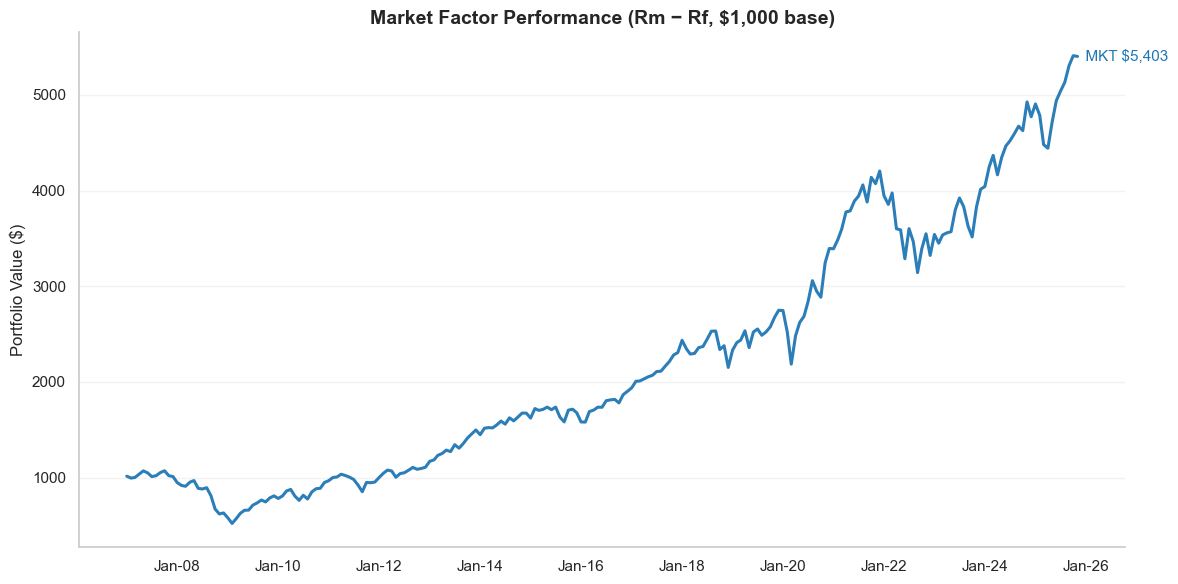

In [35]:
# ------------------------------------------------------------
# Market Factor (Rm − Rf) — Performance Output + P&L Plot
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas_datareader import data as pdr

# -----------------------------
# Styling (Quarto-friendly)
# -----------------------------
sns.set_theme(style="whitegrid")

# -----------------------------
# Parameters
# -----------------------------
START_DATE = "2007-01-01"
INITIAL_CAPITAL = 1000
ANNUALIZATION = 12  # monthly data

# -----------------------------
# Load Fama–French data
# -----------------------------
ff = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

ff = ff / 100.0
ff.index = ff.index.to_timestamp()

# -----------------------------
# Market excess return (Rm − Rf)
# -----------------------------
mkt = ff["Mkt-RF"].rename("MKT")

# -----------------------------
# Performance calculations
# -----------------------------
mkt_pnl = (1 + mkt).cumprod() * INITIAL_CAPITAL
final_value = mkt_pnl.iloc[-1]

years = len(mkt) / ANNUALIZATION
cagr = (final_value / INITIAL_CAPITAL) ** (1 / years) - 1
vol = mkt.std() * np.sqrt(ANNUALIZATION)
sharpe = mkt.mean() / mkt.std() * np.sqrt(ANNUALIZATION)

drawdown = mkt_pnl / mkt_pnl.cummax() - 1
max_dd = drawdown.min()

# -----------------------------
# Output table
# -----------------------------
performance = pd.DataFrame(
    {
        "Final Value ($)": [round(final_value, 0)],
        "CAGR (%)": [round(cagr * 100, 2)],
        "Volatility (%)": [round(vol * 100, 2)],
        "Sharpe": [round(sharpe, 2)],
        "Max Drawdown (%)": [round(max_dd * 100, 2)],
    },
    index=["Market (Rm − Rf)"]
)

print("\nMarket Factor Performance Summary\n")
display(performance)

# -----------------------------
# Plot — Cumulative P&L
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    mkt_pnl.index,
    mkt_pnl.values,
    lw=2.2,
    color="#1f77b4",
    alpha=0.95
)

ax.text(
    mkt_pnl.index[-1],
    final_value,
    f"  MKT ${final_value:,.0f}",
    fontsize=11,
    color="#1f77b4",
    va="center"
)

ax.set_title(
    "Market Factor Performance (Rm − Rf, $1,000 base)",
    fontsize=14,
    weight="bold"
)
ax.set_ylabel("Portfolio Value ($)")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()



SMB Performance Summary



,Final Value ($),CAGR (%),Volatility (%),Sharpe,Max Drawdown (%)
SMB,798.0,-1.18,9.37,-0.08,-35.41



SMB Regression Diagnostics (vs Market)



,Alpha (ann. %),Beta (MKT),R-squared,t-stat (alpha),p-value (alpha)
SMB,-2.88,0.208,0.125,-1.4,0.1622


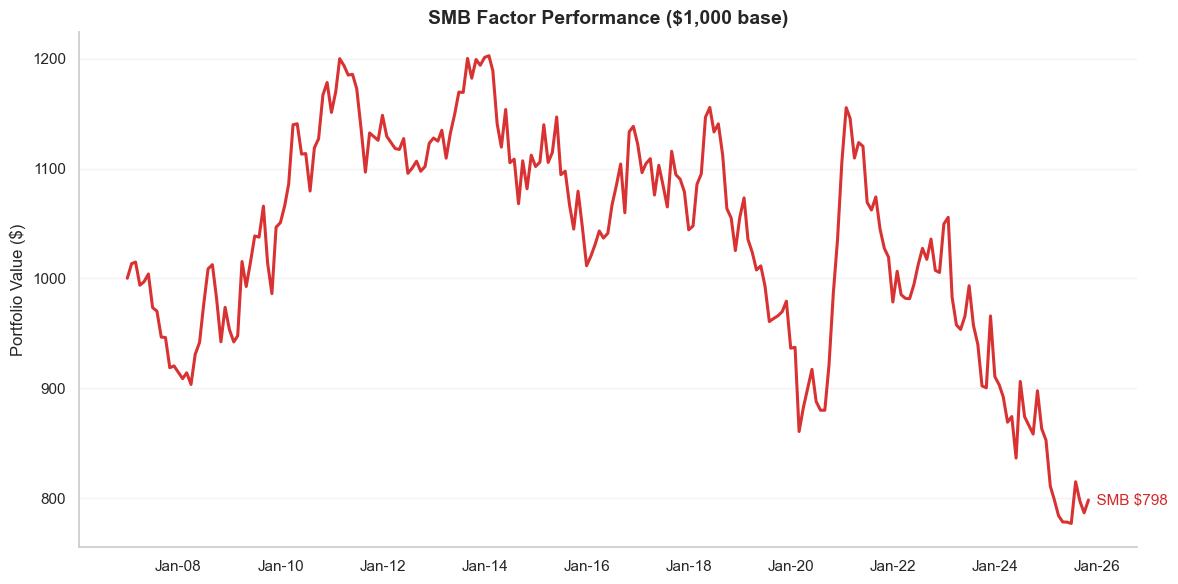

In [36]:
# ------------------------------------------------------------
# SMB Factor — Performance + Regression Diagnostics + Plot
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from pandas_datareader import data as pdr

# -----------------------------
# Styling (Quarto friendly)
# -----------------------------
sns.set_theme(style="whitegrid")

# -----------------------------
# Parameters
# -----------------------------
START_DATE = "2007-01-01"
INITIAL_CAPITAL = 1000
ANNUALIZATION = 12  # monthly

# -----------------------------
# Load Fama–French factors
# -----------------------------
ff = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

ff = ff / 100.0
ff.index = ff.index.to_timestamp()

# -----------------------------
# Factor & Market
# -----------------------------
smb = ff["SMB"].rename("SMB")
mkt = ff["Mkt-RF"].rename("MKT")

# -----------------------------
# Performance calculations
# -----------------------------
smb_pnl = (1 + smb).cumprod() * INITIAL_CAPITAL
final_value = smb_pnl.iloc[-1]

years = len(smb) / ANNUALIZATION
cagr = (final_value / INITIAL_CAPITAL) ** (1 / years) - 1
vol = smb.std() * np.sqrt(ANNUALIZATION)
sharpe = smb.mean() / smb.std() * np.sqrt(ANNUALIZATION)

drawdown = smb_pnl / smb_pnl.cummax() - 1
max_dd = drawdown.min()

performance = pd.DataFrame(
    {
        "Final Value ($)": [round(final_value, 0)],
        "CAGR (%)": [round(cagr * 100, 2)],
        "Volatility (%)": [round(vol * 100, 2)],
        "Sharpe": [round(sharpe, 2)],
        "Max Drawdown (%)": [round(max_dd * 100, 2)],
    },
    index=["SMB"]
)

print("\nSMB Performance Summary\n")
display(performance)

# -----------------------------
# Regression: SMB vs Market
# -----------------------------
X = sm.add_constant(mkt)
model = sm.OLS(smb, X).fit()

alpha = model.params["const"] * ANNUALIZATION
beta = model.params["MKT"]
r2 = model.rsquared
t_alpha = model.tvalues["const"]
p_alpha = model.pvalues["const"]

regression = pd.DataFrame(
    {
        "Alpha (ann. %)": [round(alpha * 100, 2)],
        "Beta (MKT)": [round(beta, 3)],
        "R-squared": [round(r2, 3)],
        "t-stat (alpha)": [round(t_alpha, 2)],
        "p-value (alpha)": [round(p_alpha, 4)],
    },
    index=["SMB"]
)

print("\nSMB Regression Diagnostics (vs Market)\n")
display(regression)

# -----------------------------
# Plot — Cumulative P&L
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    smb_pnl.index,
    smb_pnl.values,
    lw=2.2,
    color="#d62728",
    alpha=0.95
)

ax.text(
    smb_pnl.index[-1],
    final_value,
    f"  SMB ${final_value:,.0f}",
    fontsize=11,
    color="#d62728",
    va="center"
)

ax.set_title(
    "SMB Factor Performance ($1,000 base)",
    fontsize=14,
    weight="bold"
)
ax.set_ylabel("Portfolio Value ($)")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()


In [37]:
The SMB factor exhibits weak standalone performance over the sample, delivering a negative CAGR of –1.18% and a Sharpe ratio of –0.08, alongside a maximum drawdown exceeding 35%. Regression against the market reveals a low R² of 12.5%, indicating limited systematic exposure to broad equity risk, but also a negative and statistically insignificant alpha (–2.88% annualised, p = 0.16). These results suggest that while SMB provides diversification benefits, it does not justify a positive return expectation and is therefore treated cautiously in subsequent portfolio construction.”

SyntaxError: invalid character '–' (U+2013) (1789602755.py, line 1)


HML Performance Summary



,Final Value ($),CAGR (%),Volatility (%),Sharpe,Max Drawdown (%)
HML,609.0,-2.58,11.52,-0.17,-57.5



HML Regression Diagnostics (vs Market)



,Alpha (ann. %),Beta (MKT),R-squared,t-stat (alpha),p-value (alpha)
HML,-3.0,0.102,0.02,-1.12,0.2636


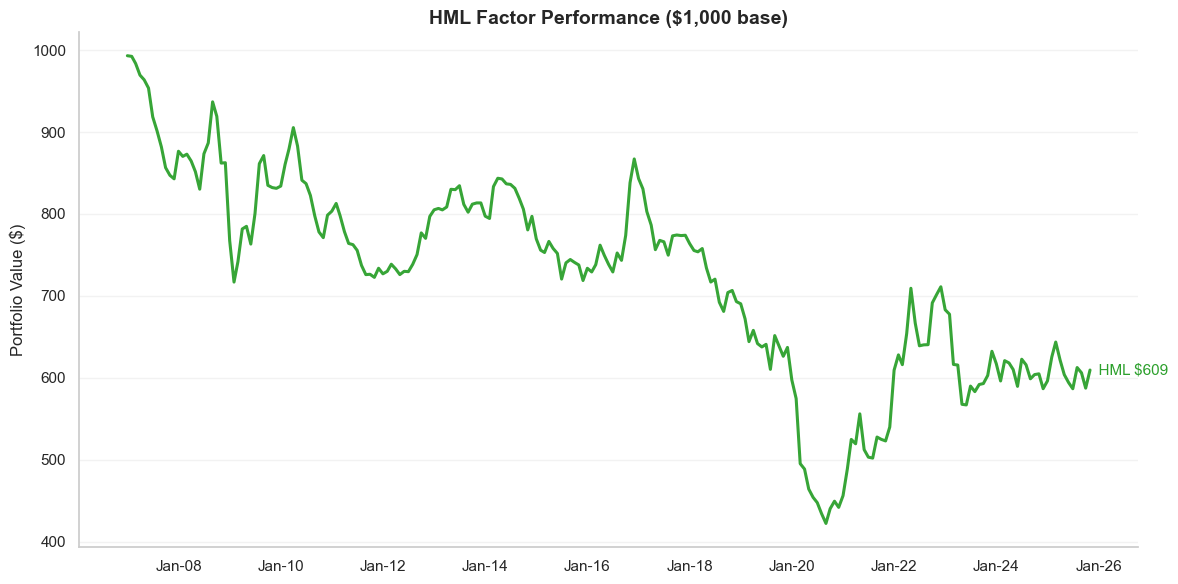

In [38]:
# ------------------------------------------------------------
# HML Factor — Performance + Regression Diagnostics + Plot
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from pandas_datareader import data as pdr

# -----------------------------
# Styling (Quarto friendly)
# -----------------------------
sns.set_theme(style="whitegrid")

# -----------------------------
# Parameters
# -----------------------------
START_DATE = "2007-01-01"
INITIAL_CAPITAL = 1000
ANNUALIZATION = 12  # monthly

# -----------------------------
# Load Fama–French factors
# -----------------------------
ff = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

ff = ff / 100.0
ff.index = ff.index.to_timestamp()

# -----------------------------
# Factor & Market
# -----------------------------
hml = ff["HML"].rename("HML")
mkt = ff["Mkt-RF"].rename("MKT")

# -----------------------------
# Performance calculations
# -----------------------------
hml_pnl = (1 + hml).cumprod() * INITIAL_CAPITAL
final_value = hml_pnl.iloc[-1]

years = len(hml) / ANNUALIZATION
cagr = (final_value / INITIAL_CAPITAL) ** (1 / years) - 1
vol = hml.std() * np.sqrt(ANNUALIZATION)
sharpe = hml.mean() / hml.std() * np.sqrt(ANNUALIZATION)

drawdown = hml_pnl / hml_pnl.cummax() - 1
max_dd = drawdown.min()

performance = pd.DataFrame(
    {
        "Final Value ($)": [round(final_value, 0)],
        "CAGR (%)": [round(cagr * 100, 2)],
        "Volatility (%)": [round(vol * 100, 2)],
        "Sharpe": [round(sharpe, 2)],
        "Max Drawdown (%)": [round(max_dd * 100, 2)],
    },
    index=["HML"]
)

print("\nHML Performance Summary\n")
display(performance)

# -----------------------------
# Regression: HML vs Market
# -----------------------------
X = sm.add_constant(mkt)
model = sm.OLS(hml, X).fit()

alpha = model.params["const"] * ANNUALIZATION
beta = model.params["MKT"]
r2 = model.rsquared
t_alpha = model.tvalues["const"]
p_alpha = model.pvalues["const"]

regression = pd.DataFrame(
    {
        "Alpha (ann. %)": [round(alpha * 100, 2)],
        "Beta (MKT)": [round(beta, 3)],
        "R-squared": [round(r2, 3)],
        "t-stat (alpha)": [round(t_alpha, 2)],
        "p-value (alpha)": [round(p_alpha, 4)],
    },
    index=["HML"]
)

print("\nHML Regression Diagnostics (vs Market)\n")
display(regression)

# -----------------------------
# Plot — Cumulative P&L
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    hml_pnl.index,
    hml_pnl.values,
    lw=2.2,
    color="#2ca02c",
    alpha=0.95
)

ax.text(
    hml_pnl.index[-1],
    final_value,
    f"  HML ${final_value:,.0f}",
    fontsize=11,
    color="#2ca02c",
    va="center"
)

ax.set_title(
    "HML Factor Performance ($1,000 base)",
    fontsize=14,
    weight="bold"
)
ax.set_ylabel("Portfolio Value ($)")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()



RMW Performance Summary



,Final Value ($),CAGR (%),Volatility (%),Sharpe,Max Drawdown (%)
RMW,1897.0,3.44,6.76,0.53,-14.18



RMW Regression Diagnostics (vs Market)



,Alpha (ann. %),Beta (MKT),R-squared,t-stat (alpha),p-value (alpha)
RMW,4.45,-0.082,0.037,2.86,0.0046


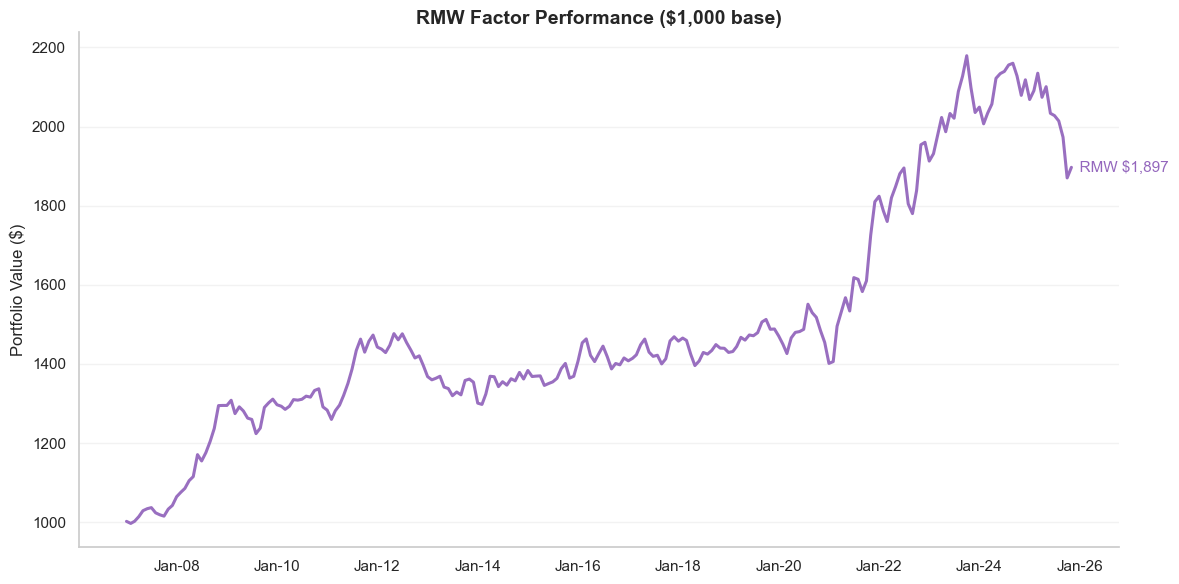

In [39]:
# ------------------------------------------------------------
# RMW Factor — Performance + Regression Diagnostics + Plot
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from pandas_datareader import data as pdr

# -----------------------------
# Styling (Quarto friendly)
# -----------------------------
sns.set_theme(style="whitegrid")

# -----------------------------
# Parameters
# -----------------------------
START_DATE = "2007-01-01"
INITIAL_CAPITAL = 1000
ANNUALIZATION = 12  # monthly data

# -----------------------------
# Load Fama–French factors
# -----------------------------
ff = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

ff = ff / 100.0
ff.index = ff.index.to_timestamp()

# -----------------------------
# Factor & Market
# -----------------------------
rmw = ff["RMW"].rename("RMW")
mkt = ff["Mkt-RF"].rename("MKT")

# -----------------------------
# Performance calculations
# -----------------------------
rmw_pnl = (1 + rmw).cumprod() * INITIAL_CAPITAL
final_value = rmw_pnl.iloc[-1]

years = len(rmw) / ANNUALIZATION
cagr = (final_value / INITIAL_CAPITAL) ** (1 / years) - 1
vol = rmw.std() * np.sqrt(ANNUALIZATION)
sharpe = rmw.mean() / rmw.std() * np.sqrt(ANNUALIZATION)

drawdown = rmw_pnl / rmw_pnl.cummax() - 1
max_dd = drawdown.min()

performance = pd.DataFrame(
    {
        "Final Value ($)": [round(final_value, 0)],
        "CAGR (%)": [round(cagr * 100, 2)],
        "Volatility (%)": [round(vol * 100, 2)],
        "Sharpe": [round(sharpe, 2)],
        "Max Drawdown (%)": [round(max_dd * 100, 2)],
    },
    index=["RMW"]
)

print("\nRMW Performance Summary\n")
display(performance)

# -----------------------------
# Regression: RMW vs Market
# -----------------------------
X = sm.add_constant(mkt)
model = sm.OLS(rmw, X).fit()

alpha = model.params["const"] * ANNUALIZATION
beta = model.params["MKT"]
r2 = model.rsquared
t_alpha = model.tvalues["const"]
p_alpha = model.pvalues["const"]

regression = pd.DataFrame(
    {
        "Alpha (ann. %)": [round(alpha * 100, 2)],
        "Beta (MKT)": [round(beta, 3)],
        "R-squared": [round(r2, 3)],
        "t-stat (alpha)": [round(t_alpha, 2)],
        "p-value (alpha)": [round(p_alpha, 4)],
    },
    index=["RMW"]
)

print("\nRMW Regression Diagnostics (vs Market)\n")
display(regression)

# -----------------------------
# Plot — Cumulative P&L
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    rmw_pnl.index,
    rmw_pnl.values,
    lw=2.2,
    color="#9467bd",  # consistent muted palette
    alpha=0.95
)

ax.text(
    rmw_pnl.index[-1],
    final_value,
    f"  RMW ${final_value:,.0f}",
    fontsize=11,
    color="#9467bd",
    va="center"
)

ax.set_title(
    "RMW Factor Performance ($1,000 base)",
    fontsize=14,
    weight="bold"
)
ax.set_ylabel("Portfolio Value ($)")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()


“Among the Fama-French factors considered, RMW exhibits the strongest standalone performance. Over the sample, the factor delivers a CAGR of 3.44% with a Sharpe ratio of 0.53 and a maximum drawdown of only 14%. Regression against the market reveals a statistically significant annualised alpha of 4.45% (t-stat = 2.86, p = 0.0046), alongside a near-zero and slightly negative market beta. The low R² of 3.7% confirms that RMW represents a largely orthogonal source of return, making it an attractive candidate for positive views in subsequent Black-Litterman optimisation.”


CMA Performance Summary



,Final Value ($),CAGR (%),Volatility (%),Sharpe,Max Drawdown (%)
CMA,920.0,-0.44,6.93,-0.03,-27.25



CMA Regression Diagnostics (vs Market)



,Alpha (ann. %),Beta (MKT),R-squared,t-stat (alpha),p-value (alpha)
CMA,0.37,-0.056,0.017,0.23,0.8183


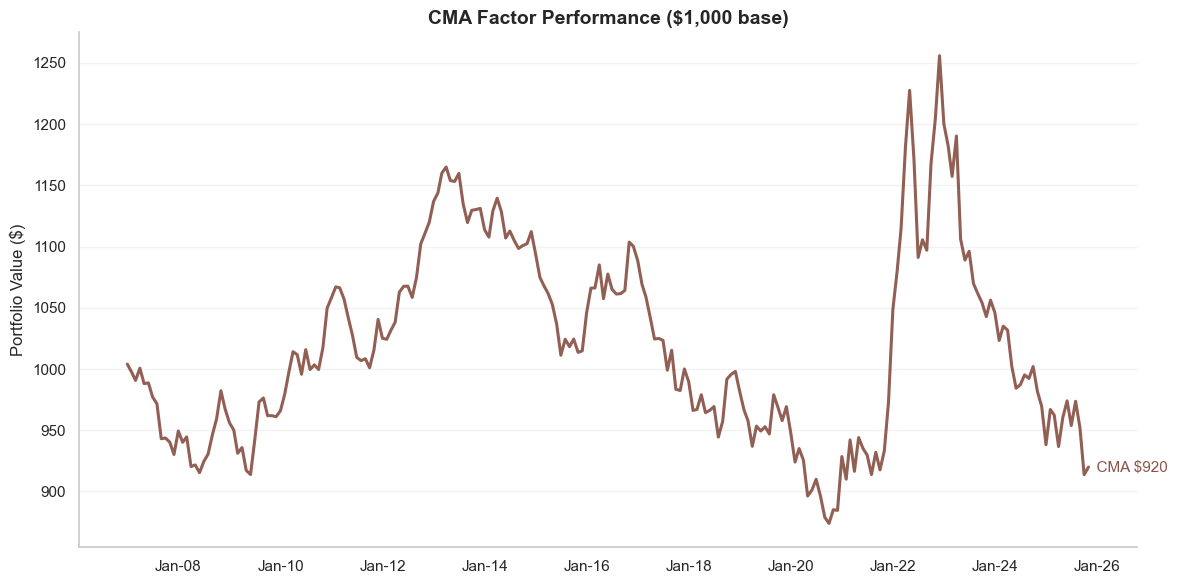

In [40]:
# ------------------------------------------------------------
# CMA Factor — Performance + Regression Diagnostics + Plot
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from pandas_datareader import data as pdr

# -----------------------------
# Styling (Quarto friendly)
# -----------------------------
sns.set_theme(style="whitegrid")

# -----------------------------
# Parameters
# -----------------------------
START_DATE = "2007-01-01"
INITIAL_CAPITAL = 1000
ANNUALIZATION = 12  # monthly data

# -----------------------------
# Load Fama–French factors
# -----------------------------
ff = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

ff = ff / 100.0
ff.index = ff.index.to_timestamp()

# -----------------------------
# Factor & Market
# -----------------------------
cma = ff["CMA"].rename("CMA")
mkt = ff["Mkt-RF"].rename("MKT")

# -----------------------------
# Performance calculations
# -----------------------------
cma_pnl = (1 + cma).cumprod() * INITIAL_CAPITAL
final_value = cma_pnl.iloc[-1]

years = len(cma) / ANNUALIZATION
cagr = (final_value / INITIAL_CAPITAL) ** (1 / years) - 1
vol = cma.std() * np.sqrt(ANNUALIZATION)
sharpe = cma.mean() / cma.std() * np.sqrt(ANNUALIZATION)

drawdown = cma_pnl / cma_pnl.cummax() - 1
max_dd = drawdown.min()

performance = pd.DataFrame(
    {
        "Final Value ($)": [round(final_value, 0)],
        "CAGR (%)": [round(cagr * 100, 2)],
        "Volatility (%)": [round(vol * 100, 2)],
        "Sharpe": [round(sharpe, 2)],
        "Max Drawdown (%)": [round(max_dd * 100, 2)],
    },
    index=["CMA"]
)

print("\nCMA Performance Summary\n")
display(performance)

# -----------------------------
# Regression: CMA vs Market
# -----------------------------
X = sm.add_constant(mkt)
model = sm.OLS(cma, X).fit()

alpha = model.params["const"] * ANNUALIZATION
beta = model.params["MKT"]
r2 = model.rsquared
t_alpha = model.tvalues["const"]
p_alpha = model.pvalues["const"]

regression = pd.DataFrame(
    {
        "Alpha (ann. %)": [round(alpha * 100, 2)],
        "Beta (MKT)": [round(beta, 3)],
        "R-squared": [round(r2, 3)],
        "t-stat (alpha)": [round(t_alpha, 2)],
        "p-value (alpha)": [round(p_alpha, 4)],
    },
    index=["CMA"]
)

print("\nCMA Regression Diagnostics (vs Market)\n")
display(regression)

# -----------------------------
# Plot — Cumulative P&L
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    cma_pnl.index,
    cma_pnl.values,
    lw=2.2,
    color="#8c564b",  # muted brown
    alpha=0.95
)

ax.text(
    cma_pnl.index[-1],
    final_value,
    f"  CMA ${final_value:,.0f}",
    fontsize=11,
    color="#8c564b",
    va="center"
)

ax.set_title(
    "CMA Factor Performance ($1,000 base)",
    fontsize=14,
    weight="bold"
)
ax.set_ylabel("Portfolio Value ($)")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()


“The CMA factor does not exhibit meaningful standalone performance over the sample period. While the factor displays low volatility and near-zero market beta, its annualised alpha of 0.37% is statistically insignificant (t-stat = 0.23). The cumulative performance ends below the initial capital, and the Sharpe ratio is negative. CMA therefore does not qualify as a return-seeking factor in isolation, though it may still play a role as a potential diversifier in multi-factor portfolios.”


MOM Performance Summary



,Final Value ($),CAGR (%),Volatility (%),Sharpe,Max Drawdown (%)
MOM,959.0,-0.22,15.69,0.07,-57.82



MOM Regression Diagnostics (vs Market)



,Alpha (ann. %),Beta (MKT),R-squared,t-stat (alpha),p-value (alpha)
MOM,4.86,-0.366,0.138,1.42,0.1562


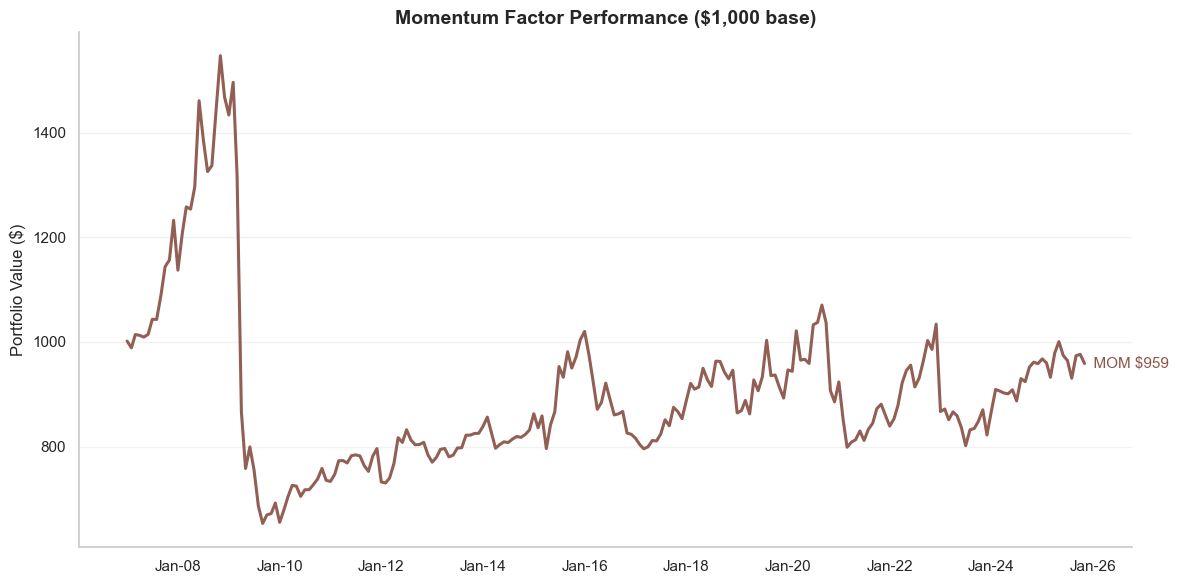

In [46]:
# ------------------------------------------------------------
# MOM Factor — Performance + Regression Diagnostics + Plot
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from pandas_datareader import data as pdr

# -----------------------------
# Styling (Quarto friendly)
# -----------------------------
sns.set_theme(style="whitegrid")

# -----------------------------
# Parameters
# -----------------------------
START_DATE = "2007-01-01"
INITIAL_CAPITAL = 1000
ANNUALIZATION = 12  # monthly data

# -----------------------------
# Load Fama–French factors + Momentum
# -----------------------------
ff5 = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

mom = pdr.DataReader(
    "F-F_Momentum_Factor",
    "famafrench",
    start=START_DATE
)[0]

# Convert from percent to decimal
ff5 = ff5 / 100.0
mom = mom / 100.0

# Convert index to timestamp
ff5.index = ff5.index.to_timestamp()
mom.index = mom.index.to_timestamp()

# -----------------------------
# Factor & Market
# -----------------------------
mom = mom["Mom"].rename("MOM")
mkt = ff5["Mkt-RF"].rename("MKT")

# Align
data = pd.concat([mom, mkt], axis=1).dropna()
mom = data["MOM"]
mkt = data["MKT"]

# -----------------------------
# Performance calculations
# -----------------------------
mom_pnl = (1 + mom).cumprod() * INITIAL_CAPITAL
final_value = mom_pnl.iloc[-1]

years = len(mom) / ANNUALIZATION
cagr = (final_value / INITIAL_CAPITAL) ** (1 / years) - 1
vol = mom.std() * np.sqrt(ANNUALIZATION)
sharpe = mom.mean() / mom.std() * np.sqrt(ANNUALIZATION)

drawdown = mom_pnl / mom_pnl.cummax() - 1
max_dd = drawdown.min()

performance = pd.DataFrame(
    {
        "Final Value ($)": [round(final_value, 0)],
        "CAGR (%)": [round(cagr * 100, 2)],
        "Volatility (%)": [round(vol * 100, 2)],
        "Sharpe": [round(sharpe, 2)],
        "Max Drawdown (%)": [round(max_dd * 100, 2)],
    },
    index=["MOM"]
)

print("\nMOM Performance Summary\n")
display(performance)

# -----------------------------
# Regression: MOM vs Market
# -----------------------------
X = sm.add_constant(mkt)
model = sm.OLS(mom, X).fit()

alpha = model.params["const"] * ANNUALIZATION
beta = model.params["MKT"]
r2 = model.rsquared
t_alpha = model.tvalues["const"]
p_alpha = model.pvalues["const"]

regression = pd.DataFrame(
    {
        "Alpha (ann. %)": [round(alpha * 100, 2)],
        "Beta (MKT)": [round(beta, 3)],
        "R-squared": [round(r2, 3)],
        "t-stat (alpha)": [round(t_alpha, 2)],
        "p-value (alpha)": [round(p_alpha, 4)],
    },
    index=["MOM"]
)

print("\nMOM Regression Diagnostics (vs Market)\n")
display(regression)

# -----------------------------
# Plot — Cumulative P&L
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    mom_pnl.index,
    mom_pnl.values,
    lw=2.2,
    color="#8c564b",  # same muted brown family
    alpha=0.95
)

ax.text(
    mom_pnl.index[-1],
    final_value,
    f"  MOM ${final_value:,.0f}",
    fontsize=11,
    color="#8c564b",
    va="center"
)

ax.set_title(
    "Momentum Factor Performance ($1,000 base)",
    fontsize=14,
    weight="bold"
)
ax.set_ylabel("Portfolio Value ($)")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()


Momentum exhibits positive but statistically weak alpha
Returns are highly regime-dependent
Severe drawdowns indicate crash risk, consistent with literature
Negative market beta suggests diversification potential
Momentum is therefore not used as a standalone return driver
Instead, it is retained for cross-factor diversification


Combined Factor Performance Summary



,Final Value ($),CAGR (%),Volatility (%),Sharpe,Max Drawdown (%)
Combined Factors,1051.0,0.26,4.47,0.08,-15.32



Combined Factor Regression Diagnostics (vs Market)



,Alpha (ann. %),Beta (MKT),R-squared,t-stat (alpha),p-value (alpha)
Combined Factors,0.76,-0.039,0.019,0.73,0.4637


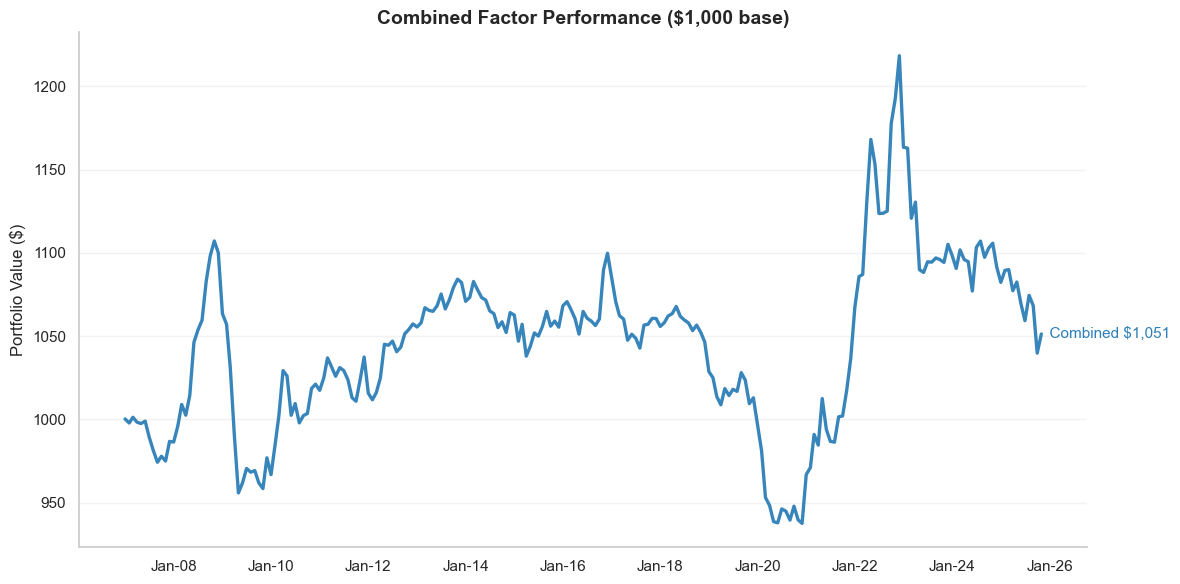

In [45]:
# ------------------------------------------------------------
# Combined Factor Basket — Performance + Regression + Plot
# FF5 + Momentum (CORRECT DATA SOURCING)
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
from pandas_datareader import data as pdr

# -----------------------------
# Styling (Quarto friendly)
# -----------------------------
sns.set_theme(style="whitegrid")

# -----------------------------
# Parameters
# -----------------------------
START_DATE = "2007-01-01"
INITIAL_CAPITAL = 1000
ANNUALIZATION = 12  # monthly

# -----------------------------
# Load Fama–French 5 Factors
# -----------------------------
ff5 = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

ff5 = ff5 / 100.0
ff5.index = ff5.index.to_timestamp()

# -----------------------------
# Load Momentum Factor (SEPARATE DATASET)
# -----------------------------
mom = pdr.DataReader(
    "F-F_Momentum_Factor",
    "famafrench",
    start=START_DATE
)[0]

mom = mom / 100.0
mom.index = mom.index.to_timestamp()
mom = mom.rename(columns={"Mom": "MOM"})

# -----------------------------
# Merge Factors (CRITICAL FIX)
# -----------------------------
factors = ff5[["SMB", "HML", "RMW", "CMA"]].join(mom, how="inner")
market = ff5["Mkt-RF"].rename("MKT")

# Align market
market = market.loc[factors.index]

# -----------------------------
# Combined Factor Return (Equal Weight)
# -----------------------------
combined_return = factors.mean(axis=1)

# -----------------------------
# Performance Calculations
# -----------------------------
pnl = (1 + combined_return).cumprod() * INITIAL_CAPITAL
final_value = pnl.iloc[-1]

years = len(pnl) / ANNUALIZATION
cagr = (final_value / INITIAL_CAPITAL) ** (1 / years) - 1
vol = combined_return.std() * np.sqrt(ANNUALIZATION)
sharpe = combined_return.mean() / combined_return.std() * np.sqrt(ANNUALIZATION)

drawdown = pnl / pnl.cummax() - 1
max_dd = drawdown.min()

performance = pd.DataFrame(
    {
        "Final Value ($)": [round(final_value, 0)],
        "CAGR (%)": [round(cagr * 100, 2)],
        "Volatility (%)": [round(vol * 100, 2)],
        "Sharpe": [round(sharpe, 2)],
        "Max Drawdown (%)": [round(max_dd * 100, 2)],
    },
    index=["Combined Factors"]
)

print("\nCombined Factor Performance Summary\n")
display(performance)

# -----------------------------
# Regression: Combined vs Market
# -----------------------------
X = sm.add_constant(market)
model = sm.OLS(combined_return, X).fit()

alpha = model.params["const"] * ANNUALIZATION
beta = model.params["MKT"]
r2 = model.rsquared
t_alpha = model.tvalues["const"]
p_alpha = model.pvalues["const"]

regression = pd.DataFrame(
    {
        "Alpha (ann. %)": [round(alpha * 100, 2)],
        "Beta (MKT)": [round(beta, 3)],
        "R-squared": [round(r2, 3)],
        "t-stat (alpha)": [round(t_alpha, 2)],
        "p-value (alpha)": [round(p_alpha, 4)],
    },
    index=["Combined Factors"]
)

print("\nCombined Factor Regression Diagnostics (vs Market)\n")
display(regression)

# -----------------------------
# Plot — Combined Cumulative P&L
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    pnl.index,
    pnl.values,
    lw=2.4,
    color="#2c7fb8",  # same calm blue as earlier
    alpha=0.95
)

ax.text(
    pnl.index[-1],
    final_value,
    f"  Combined ${final_value:,.0f}",
    fontsize=11,
    color="#2c7fb8",
    va="center"
)

ax.set_title(
    "Combined Factor Performance ($1,000 base)",
    fontsize=14,
    weight="bold"
)
ax.set_ylabel("Portfolio Value ($)")

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
ax.xaxis.set_major_locator(mdates.YearLocator(2))

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()
